# Wide-field observations of PSF variations with SCAO

This notebook can be found in the [MICADO package on the IRDB Github repository](https://github.com/astronomyk/irdb/blob/master/MICADO/docs/static/)

In this example we will show the effect of the off-axis AO correction on the shape of the PSF when observing with the SCAO mode.
To make a semi-realistic observation, we will observe an open cluster created by the ``ScopeSim_Templates`` package.
This cluster extends over the full MICADO field of view.
As such it should show the full extend of the expected PSF variations over the field.

It should be noted that adding PSF field variations is a computationally expensive process. ScopeSim does it's best to reduce the level of complexity by discretising the PSF variation into different zones over the field of view.
Occasionally the borders between these zones is visible 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u

import scopesim as sim
import scopesim_templates as sim_tp

%matplotlib inline
%config Completer.use_jedi = False

The PSF field-variation is complex and computationally expensive.
Hence this functionality is not inluded in the ``MICADO_Sci`` package.
For use cases requireing field variations we must use the pipeline-oriented ``MICADO`` package.
As we will be using the SCAO mode, we can ignore the ``MAORY`` module.

In [2]:
sim.download_package(["locations/Armazones.zip",
                      "telescopes/ELT.zip",
                      "instruments/MICADO.zip"])

['F:\\temp\\scopesim_fdr_notebooks\\Armazones.zip',
 'F:\\temp\\scopesim_fdr_notebooks\\ELT.zip',
 'F:\\temp\\scopesim_fdr_notebooks\\MICADO.zip']

### Set up an open cluster ``Source`` object

The first step is to create a ``Source`` object. 
Here we take advantage of the ``cluster`` function from the ``ScopeSim_Templates.basic.stars`` submodule.
The ``cluster`` function draws masses from an standard Kroupa IMF until the ``mass`` limit has been reached.
It then generates randomly draw positions from a 2D gaussian distribution with a HWHM equal to the given ``core_radius`` in parsec.
The ``distance`` parameter sets the distance in parsec to the centre of the cluster.
This allows the final on-sky star positions in units of ``arcsec`` from the centre of the cluster to be calculated.
Spectra for all the stars are taken from the Pickles (1998) catalogue and are imported from the ``Pyckles`` python packages.

Here we choose a cluster with a mass of 10000 solar masses (~250000 stars) with a core radius of 0.5 parsec, located at a distance of 8 kpc from the Earth.
This essentially gives us a cluster that covers the whole MICADO filed of view in wide-field mode (4mas / pixel).

In [3]:
cluster = sim_tp.basic.stars.cluster(mass=10000, core_radius=0.5, distance=8000)

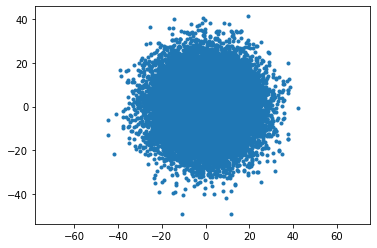

In [4]:
plt.plot(cluster.fields[0]["x"], cluster.fields[0]["y"], ".")
plt.axes().set_aspect('equal', 'datalim')

### Set up the MICADO optical system for SCAO and include a field-varying PSF

The next step is the standard proceedure - set the instrument to ``MICADO`` and the modes to ``SCAO`` and ``IMG_4mas``, then create an ``OpticalTrain`` object.

In [5]:
cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["SCAO", "IMG_4mas"])
micado = sim.OpticalTrain(cmd)

By default the PSF model in the pipeline-oriented ``MICADO`` package is set to use a field-constant PSF cube.
We need to change this to use a Field-Varying PSF model.

**Note:** to view all the optical effects contained within the optical model, use the ``.effects`` attribute in the ``OpticalTrain`` class.

Here we see the PSF model in the 4th last line:

In [6]:
micado.effects

element,name,class,included,z_orders
str21,str32,str31,bool,object
armazones,armazones_atmo_default_ter_curve,AtmosphericTERCurve,True,"[111, 511]"
armazones,armazones_atmo_dispersion,AtmosphericDispersion,False,[231]
armazones,armazones_atmo_skycalc_ter_curve,SkycalcTERCurve,False,"[112, 512]"
ELT,scope_surface_list,SurfaceList,True,"[20, 120, 520]"
ELT,scope_vibration,Vibration,True,"[244, 744]"
ELT,eso_combined_reflection,TERCurve,False,"[10, 110, 510]"
MICADO,micado_static_surfaces,SurfaceList,True,"[20, 120, 520]"
MICADO,micado_ncpas_psf,NonCommonPathAberration,True,"[241, 641]"
MICADO,filter_wheel_1,FilterWheel,True,"[124, 224, 524]"


We can access the PSF model using the standard python dictionary notion using the name of the element.
In this case it is called ``relay_psf`` as this refers to the internal MICADO relay optics which are connected to the SCAO system.

We do not want to use the default ``relay_psf`` object, so we need to tell ScopeSim not to include it

In [7]:
micado["relay_psf"].include = False

Next we want to add a ``FieldVaryingPSF`` object from the ScopeSim library of optical effect.
Before we initialise the object though, we will need the correct PSF cube.

A small library of precomputed PSFs can be found on the ScopeSim server: https://www.univie.ac.at/simcado/InstPkgSvr/psfs/

Once we have downloaded the PSF cube of our choice (in this case the cube corresponding to ESO median atmospheric conditions) we can pass the file path to the ``FieldVaryingPSF`` object.

In [8]:
fname = "AnisoCADO_SCAO_FVPSF_4mas_EsoMedian_20190328.fits"
fv_psf = sim.effects.psfs.FieldVaryingPSF(filename=fname, name="SCAO_FV_PSF")

We now need to add the new PSF to the MICADO relay optics element inside the ``MICADO`` optical train.

In [9]:
micado.optics_manager["default_ro"].add_effect(fv_psf)

Viewing an on-axis PSF is boring. Therefore we will move the 1024x1024 detector window off centre 10 arcseconds in both x and y directions.
We will also increase the exposure time to 60 seconds.

Now we are ready to observe and readout the MICADO detector window

In [10]:
micado.cmds["!OBS.dit"] = 600    # [s]
micado.cmds["!DET.x"] = 2500     # [pixel] equivalent of 10 arcseconds (10 arcsec / 0.004 arcsec pixel-1)
micado.cmds["!DET.y"] = 2500

micado.observe(cluster)
hdus = micado.readout()

Preparing 2 FieldOfViews


The elongation of the PSF along the radial axis is quite visible.

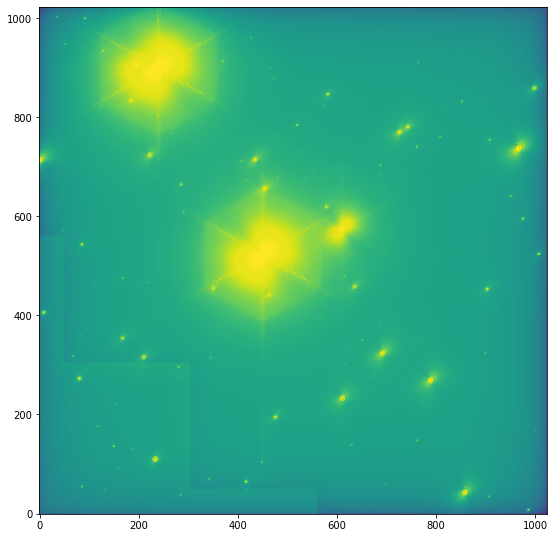

In [11]:
plt.figure(figsize=(20, 20))
plt.subplot(121)
im = hdus[0][1].data
plt.imshow(im, origin="lower", norm=LogNorm())

Alternatively we could re-centre the detector window, but expand the window size to 4096x4096 pixels (16x16 arcsecond) which is the equivalent of the central MICADO detector.

In [12]:
micado.cmds["!DET.x"] = 0     
micado.cmds["!DET.y"] = 0
micado.cmds["!DET.width"] = 4096
micado.cmds["!DET.height"] = 4096

micado.observe(cluster)
hdus = micado.readout()

Preparing 2 FieldOfViews


It should be noted, the larger the detector size, the longer the simulation takes to run.
Hence the option to simply shift the detector centre while keeping the detector size small.

This option does however let us see the change in orientation of the PSF elongation around the on-axis position

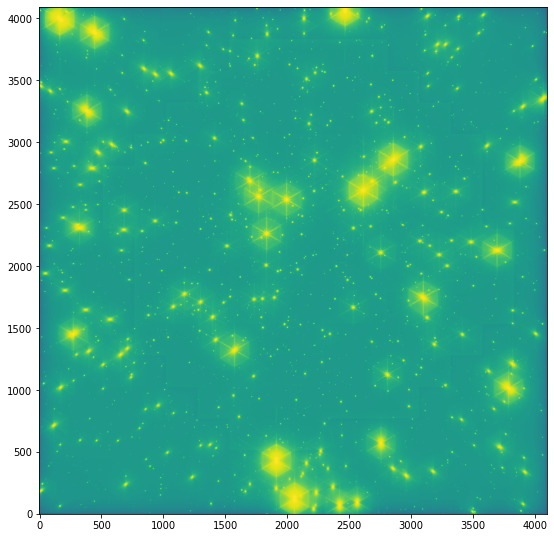

In [13]:
plt.figure(figsize=(20, 20))
plt.subplot(121)
im = hdus[0][1].data
plt.imshow(im, origin="lower", norm=LogNorm())

### Swap between a detector window and the full detector array

**WARNING! It is ONLY recommended to run the full MICADO detector configuration is you have >8 GB of RAM**

While the ``MICADO_Sci`` package only has a customisable detector window for simulated observations, the ``MICADO`` package contains a full description of the 9 detectors in the MICADO detector array.

This requires simulating a ~13000x13000 pixel field, which understandable takes a lot of computer resources and takes on the **order of 10 minutes to run.**



Ideally the user would write a script using the commands in this notebook and run that script in the background.

That said, swapping to the full detector array is a simple matter of setting the ``.include`` parameter to ``True`` and ``False`` for the two Detector options provided in the ``MICADO`` package (see ``micado.effects`` table above).

In [14]:
micado["full_detector_array"].include = True
micado["detector_window"].include = False

In this case, it is worth saving the final ``HDUList`` to disk as a multi-extension FITS file so the data are safe in case something happens to the Python session

In [15]:
# micado.observe(cluster)
# micado.readout(filename="micado_full_detector.fits")